In [3]:
import os
import datetime
import pandas as pd
import xarray as xr
import boto3
import s3fs
from io import BytesIO, StringIO
import sys
sys.path.append("../")
from qaqc_utils import *

In [4]:
def file_on_s3(da):
    files = [] # Get files
    for item in s3.Bucket(bucket_name).objects.filter(Prefix = da['cleandir'].iloc[0]):
        file = str(item.key)
        files += [file]
    file_st = [f.split(".nc")[0].split("/")[-1] for f in files if f.endswith(".nc")]
    return  da['era-id'].isin(file_st)


In [8]:
def read_network_files_training():
    df = pd.read_csv("../temp_clean_all_station_list.csv")
    df['rawdir'] = df["network"].apply(lambda row: "1_raw_wx/{}/".format(row))
    df['cleandir'] = df["network"].apply(lambda row: "2_clean_wx/{}/".format(row))
    df['qaqcdir'] = df["network"].apply(lambda row: "3_qaqc_wx_dev/{}/".format(row))
    df['mergedir'] = df["network"].apply(lambda row: "4_merge_wx/{}/".format(row))
    df['key'] = df.apply(lambda row: row['cleandir']+row['era-id']+".nc", axis=1)
    df['exist'] = np.zeros(len(df)).astype("bool")
    for n in df['network'].unique():
        print(n)
        ind = df['network']==n
        df.loc[ind,'exist'] = file_on_s3(df[ind])
    df = df[df['exist']]
    df['file_size'] = df['key'].apply(lambda row: s3_cl.head_object(Bucket=bucket_name, Key=row)['ContentLength'])
    df = df.sort_values(by=["file_size","network","era-id"]).drop(columns="exist")
    num_groups = len(df)//(72*3)
    total_size = df['file_size'].sum()
    target_size = total_size / num_groups
    target_size
    groups = []
    current_group = []
    current_group_size = 0
    df_sorted = df.sort_values(by='file_size', ascending=False)
    # for index, row in df_sorted.iterrows():
    #     if current_group_size + row['file_size'] > target_size and current_group:
    #         groups.append(pd.DataFrame(current_group))
    #         current_group = []
    #         current_group_size = 0
    #     current_group.append(row)
    #     current_group_size += row['file_size']
    # if current_group:
    #     groups.append(pd.DataFrame(current_group))
    # final_df = pd.concat([df.assign(Group=i) for i, df in enumerate(groups)]).reset_index(drop=True).drop(columns="Group")
    return df

In [9]:
%%time
df = read_network_files_training()

ASOSAWOS
CAHYDRO
CDEC
CIMIS
CNRFC
CRN
CW3E
CWOP
HADS
HNXWFO
HOLFUY
HPWREN
LOXWFO
MAP
MARITIME
MTRWFO
NCAWOS
NDBC
NOS-NWLON
NOS-PORTS
OtherISD
RAWS
SCAN
SGXWFO
SHASAVAL
SNOTEL
VCAPCD
CPU times: user 1min 9s, sys: 2.89 s, total: 1min 12s
Wall time: 22min 44s


In [10]:
df.to_csv("clean_all_station_list_wsize.csv")

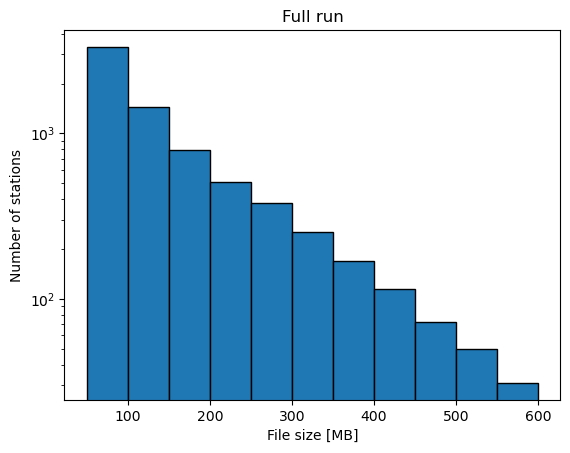

In [15]:
fig,ax = plt.subplots()
(df['file_size']/1e6).plot.hist(ax=ax, bins=np.arange(50,650,50), edgecolor='black', facecolor='C0')
ax.set_yscale("log")
ax.set_ylabel("Number of stations")
ax.set_xlabel("File size [MB]")
ax.set_title("Full run");

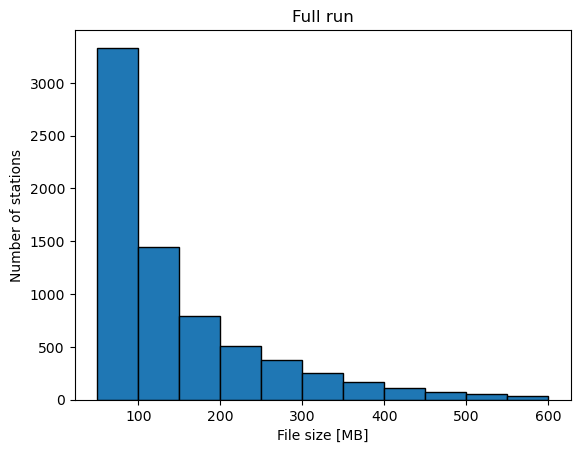

In [16]:
fig,ax = plt.subplots()
(df['file_size']/1e6).plot.hist(ax=ax, bins=np.arange(50,650,50), edgecolor='black', facecolor='C0')
ax.set_ylabel("Number of stations")
ax.set_xlabel("File size [MB]")
ax.set_title("Full run");